# Running simulations using Pop2net

In the previous part of this introduction, we have learned how to use Pop2net to build, evaluate and export networks.
In the following part of this introduction, we will learn how to use Pop2net to directly run a simulation based on the defined network.
To perform simulations, Pop2net relies on [AgentPy](https://agentpy.readthedocs.io/en/latest/#) - a general ABM framework.
We recommend you to familiarize yourself with AgentPy first, as only some aspects of AgentPy are covered in this introduction.

In the following, we programme a simple infection simulation as an example of how to use pop2net to run simulations.

In [1]:
# this is a hidden cell which sets seeds for consistent outputs

import random

import numpy as np

random.seed(0)
np.random.seed(0)

## DataFaker

In the previous example, we used example data to create the population of agents.
In this example, we also use *fake* data, but this time we use a data generator provided by Pop2net to generate the data.
The DataFaker creates a data set of any size, which is similar to a classic survey data set.
`pop2net.data_fakers.soep_faker` creates data similiar to the [German Socio-Economic Panel](https://www.diw.de/en/diw_01.c.678568.en/research_data_center_soep.html).

We start by creating a dataset of 1000 rows:

In [2]:
import pop2net as p2n
from pop2net.data_fakers.soep import soep_faker

df_soep = soep_faker.soep(size=1000, seed=1000000)
df_soep.head()

,age,gender,work_hours_day,nace2_division,hid,pid
0,74.0,female,0.000000,-2,1434,2344
1,31.0,female,7.473384,87,1434,695
2,24.0,male,0.396244,1,1434,2077
3,77.0,female,0.000000,-2,5711,346
4,26.0,female,0.000000,-2,5711,5288


## Designing the simulation

The object class `Model` is the key component of implementing simulation models using pop2net (or AgentPy).
The class `Model` integrates all elements of the simulation and determines the simulation sequences.

`Model` has four core methods that structure the processes of the simulation model:

1. `Model.setup()`
2. `Model.step()`
3. `Model.update()`
4. `Model.end()`

Please refer to the [AgentPy documentation](https://agentpy.readthedocs.io/en/latest/reference_model.html) for more detailed information on those methods.

In addition to an *empty* `Agent` class and an *empty* `MagicLocation` class, we define our first own `Model` class below.
First we define the method `setup()`, which is executed according to the AgentPy logic at the beginning of the simulation.
Within the `setup()` method, we do nothing more than create a `Creator` as usual and then create agents and locations.

In [3]:
class Agent(p2n.Agent):
    pass


class Home(p2n.MagicLocation):
    pass


class InfectionModel(p2n.Model):
    def setup(self):
        self.creator = p2n.Creator(model=self)
        self.creator.create(
            df=df_soep,
            agent_class=Agent,
            location_classes=[Home],
        )

Now, we execute the simulation model.
Again, please refer to the [AgentPy documentation](https://agentpy.readthedocs.io/en/latest/overview.html#running-a-simulation) if needed.

In [4]:
model = InfectionModel()
results = model.run(steps=50)

Completed: 50 steps
Run time: 0:00:01.196994
Simulation finished


The simulation has now run, but practically nothing has happened except that the agents and locations have been created.

In [5]:
model.agents

AgentList (1000 objects)

In [6]:
model.locations

LocationList (1 object)

Now we add some code to make the model a working infection simulation.
We add the attributes `infection_status` and `days_since_infection` as well as the methods `infect` and `update_infection_status` to the agent.

What is relevant here is how the agent accesses other agents with which it is in contact.
This is done using the `agent.neighbors()` method.
On the other hand, it is relevant how the agent determines *how much* contact it has or has had with the other agents.
This is done using the method `agent.get_agent_weight()`.
Both methods include all locations that an agent visits.

In [7]:
import random


class Agent(p2n.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    infection_probability = 0.01 * self.get_agent_weight(agent_v)

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"

            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

Next, we define 4 locations.
A home `Home`, to which all agents of a household are assigned, a workplace `Work`, which groups the agents according to their occupational sectors, and a school `School`, which contains age-specific classes.
To ensure that each agent has contact with at least two other agents, we also define the location `Ring`, which connects the entire population along a ring using the predefined pop2net class `RingLocation`.

In [8]:
import networkx as nx


class Home(p2n.MagicLocation):
    def split(self, agent):
        return agent.hid

    def weight(self, agent):
        return 12


class Work(p2n.MagicLocation):
    n_agents = 10

    def filter(self, agent):
        return True if agent.work_hours_day > 0 and agent.nace2_division > 0 else False

    def split(self, agent):
        return agent.nace2_division

    def weight(self, agent):
        return agent.work_hours_day


class School(p2n.MagicLocation):
    n_agents = 25

    def filter(self, agent):
        return True if 6 <= agent.age <= 18 else False

    def split(self, agent):
        return agent.age

    def weight(self, agent):
        return 6


class Ring(p2n.MagicLocation):
    def setup(self):
        self.nxgraph = nx.cycle_graph(n=len(self.model.agents))

We extend the `InfectionModel` so that 10 random agents are infected at the start of the simulation (`setup()`).
In `step()` we define what should happen in each individual time step of the simulation.
First, the method `update_infection_status()` is to be executed for each agent and then the method `infect()` for each agent.
If you are wondering about the strange syntax, have a look [here](https://agentpy.readthedocs.io/en/latest/overview.html#agent-sequences).
The method `update()` is also executed in each time step, but always after the method `step()`.
In `update()` we collect the number of agents ever infected per time step in order to visualize it after the simulation.

In [9]:
class InfectionModel(p2n.Model):
    def setup(self):
        self.creator = p2n.Creator(model=self)
        self.creator.create(
            df=df_soep,
            agent_class=Agent,
            location_classes=[
                Home,
                Work,
                School,
                Ring,
            ],
        )

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"

        self.inspector = p2n.NetworkInspector(model=self)

    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )

Let's execute the model:

In [10]:
model = InfectionModel()
results = model.run(steps=50)

Completed: 50 steps
Run time: 0:00:11.173747
Simulation finished


Below, you can see the number of infections per time step.

Text(0, 0.5, 'Infections')

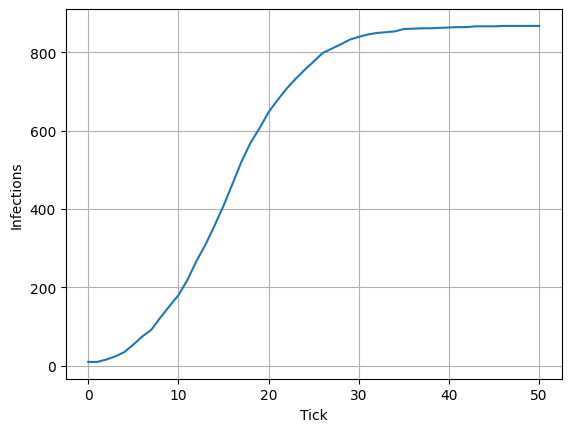

In [11]:
import matplotlib.pyplot as plt

data1 = results.variables.InfectionModel.cumulative_infections

plt.plot(data1)
plt.grid()
plt.xlabel("Tick")
plt.ylabel("Infections")

Just because we can, let's have look at the network:

In [12]:
model.inspector.plot_bipartite_network()

In [13]:
model.inspector.plot_agent_network()

## Simulations on dynamic networks

Up to now, we have had purely static networks that have not changed once they have been created.
In pop2net, there are two ways to change the networks during the simulation.
Firstly, agents can leave and join locations using the location methods `remove_agent()` and `add_agent()`, for instance.
If a complete *move* of the agent from one location to another is not necessary, the connection weights between the agent and the location can also simply be varied.
In the following, we will have a look at this method to create dynamic networks.

We now want to add another property to the infection simulation: Agents only visit the school or workplace if they are not currently symptomatically ill.

In order to exclude agents who are symptomatically ill from schools and workplaces, we adapt the `weight()` method in each case.
By default, the `weight()` method is executed repeatedly in each time step for each location so that the weights are always up to date
(as this can affect the performance of the simulation, you can set the attribute `static_weight = True` to deactivate this function).

In [14]:
class Home(p2n.MagicLocation):
    def split(self, agent):
        return agent.hid

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 3
        else:
            return 12

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))


class Work(p2n.MagicLocation):
    n_agents = 10

    def filter(self, agent):
        return True if agent.work_hours_day > 0 and agent.nace2_division > 0 else False

    def split(self, agent):
        return agent.nace2_division

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 0
        else:
            return agent.work_hours_day

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))


class School(p2n.MagicLocation):
    n_agents = 25

    def filter(self, agent):
        return True if 6 <= agent.age <= 18 else False

    def split(self, agent):
        return agent.age

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 0
        else:
            return 6

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))


class Ring(p2n.MagicLocation):
    def setup(self):
        self.nxgraph = nx.cycle_graph(n=len(self.model.agents))

In [15]:
import datetime as dt


class InfectionModel(p2n.Model):
    def setup(self):
        self.creator = p2n.Creator(model=self)
        self.creator.create(
            df=df_soep,
            agent_class=Agent,
            location_classes=[
                Home,
                Work,
                School,
                Ring,
            ],
        )
        self.date = dt.date(2022, 1, 1)

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"

    def step(self):
        self.update_weights(location_classes=[Home, School, Work])
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )

In [16]:
class Agent(p2n.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    contact_weight = self.get_agent_weight(agent_v)
                    infection_probability = 0.01 * contact_weight

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 1 <= self.days_since_infection <= 2:
                self.infection_status = "infectious"

            elif 3 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [17]:
model = InfectionModel()
results = model.run(steps=50)

Completed: 50 steps
Run time: 0:00:11.124869
Simulation finished


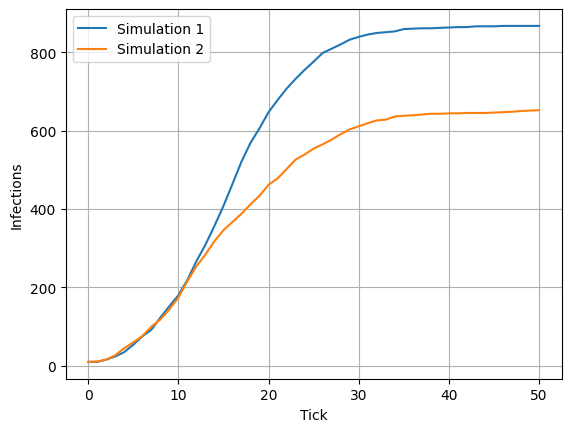

In [18]:
data2 = results.variables.InfectionModel.cumulative_infections

plt.plot(data1, label="Simulation 1")
plt.plot(data2, label="Simulation 2")
plt.xlabel("Tick")
plt.ylabel("Infections")
plt.legend()
plt.grid()